<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/ML01%20%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0%E3%81%A8SOM/L0042_COLOR_SOM_2_%E8%87%AA%E5%B7%B1%E7%B5%84%E7%B9%94%E5%8C%96%E3%83%9E%E3%83%83%E3%83%95%E3%82%9A%E3%81%AB%E3%82%88%E3%82%8B%E8%89%B2%E5%88%86%E9%A1%9E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 自己組織化マップ（SOM)＆クラスタリング 2

絵画に使われている色を、先に作った自己組織化マップのプログラムで解析している。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import urllib.request
import io
import PIL.Image
import cv2
from IPython.display import HTML,display

# ネット上の画像を取ってくるメソッド
def url2img(url):
    print(url)
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:47.0) Gecko/20100101 Firefox/47.0",
        }
    f = io.BytesIO(urllib.request.urlopen(urllib.request.Request(url=url, headers=headers)).read())
    img = PIL.Image.open(f)
    imgArray = np.asarray(img)
    return imgArray

# 画像から　色を　num 個ピックアップするメソッド
def pickcolor(imgArray, num):
    w = imgArray.shape[1]
    h = imgArray.shape[0]
    ret = []
    for i in range(num):
        rw = int(w*np.random.rand())
        rh = int(h*np.random.rand())
        ret.append(imgArray[rh,rw]/255)
    return ret

In [2]:
import scipy.stats as st
# ガウス分布
def gkern(kernlen=21, nsig=3):
    # kernlen カーネルの縦横のサイズ　nsig : 標準偏差
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x)) # 正規分布の差分
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d)) # 外積の平方根
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# 自己組織化マップ SOM を生成する　　　　
# M :２次元配置されたニューロンの重み配列    
# x : 入力データ,  alpha：学習係数  kzize：ぼかし具合
def organize_som(M, x, alpha=0.3, ksize=3):
    gk = gkern(2*ksize+1,ksize)/np.max(gkern(2*ksize+1,ksize)) # ガウス分布
    mini, minj = get_winner(M,x)
    MM = np.zeros((M.shape[0]+2*ksize, M.shape[1]+2*ksize,3),np.float64)
    MM[ksize:-ksize,ksize:-ksize]=M
    for i in range(-ksize,ksize+1): #  勝者の近傍7x7 の範囲を与えられたデータ（このプログラムでは色）に近づける
        for j in range(-ksize,ksize+1):
            try: #　勝者の近傍への影響はガウス分布に従い、遠ざかるほど小さくしていく
                MM[ksize+mini+i,ksize+minj+j] += alpha * (x - MM[ksize+mini+i,ksize+minj+j])*gk[ksize+i,ksize+j]
            except:
                pass
    return MM[ksize:-ksize,ksize:-ksize]

# マップの表示
def show_som(M):
    im = plt.imshow(M,interpolation='nearest',origin='lower')
    return im

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj

# 配列３次元M（ただし最後の次元は３要素でありカラーデータとみなせるもの）を matplot 画像データとして返す
def show_som(M):
    im = plt.imshow(M,interpolation='none',origin='lower')
    return im

# K-means 法によりマップの要素であるノードをクラスタリングする
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    (row,col,ch) = M.shape
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

from matplotlib.colors import LinearSegmentedColormap
# カスタムカラーマップの生成
def generate_cmap(centers):
    lebels = len(centers)
    values = range(lebels)
    color_list = centers # ３次元データの重心の値そのものをカラーデータとみなす
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

# 境界の描画
def plotBoundary(labels, somcenters, cmap='tab20', colorbar=True):
    row,col = labels.shape
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
    
    if colorbar:
        plt.colorbar()
        
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))
        
# COLOR_SOM メインプログラム
def color_som(url,ax=None):
    # ネット上から画像データを取得し大きさを規格化
    imgArray = url2img(url) # 画像データの取得
    h,w = imgArray.shape[:2]
    imgArray0 = cv2.resize(imgArray,(200,200*h//w)) # サイズを規格化
    display(PIL.Image.fromarray(imgArray0)) # 確認のための表示

    # MAPサイズ
    row = 20  # 高さ
    col = 30 # 幅
    W = np.random.random([row,col,3]) # Map 用の配列

    # SOMのパラメータ
    learntime = 50 # 繰り返し学習回数
    batchsize = 128 # １回の繰り返しで採取するデータの数
    alpha = 0.3 # 学習係数

    # 競合学習のループ
    fig = plt.figure()
    plt.axis('off')
    ims = [] # 
    for time in range(learntime):
        pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
        for color in pcolors:
            W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
        ims.append([show_som(W)])  # アンメーション用にマップを画像として蓄積

    ani = animation.ArtistAnimation(fig, ims , repeat=False) 
    display(HTML(ani.to_jshtml())) 
    return W

# 代表色を k 色選んでMAPのノード（重み）をクラスタリング
def som_clustering(W,k=12):
    labelimage, centers = kmeans(W,k,100)
    somcenters = [get_winner(W,c)  for c in centers]
    # print("代表色",somcenters)
    custom_cmap = generate_cmap(centers)
    plotBoundary(labelimage, somcenters, cmap=custom_cmap)

# デモ用関数
def ColorSOMDemo(url,k1=6,k2=12):
    W = color_som(url)
    plt.figure(figsize = (12,3), facecolor="lightgray")
    plt.subplot(1,2,1)
    plt.axis('off')
    som_clustering(W,k=6)
    plt.subplot(1,2,2)
    som_clustering(W,k=12)
    plt.axis('off')
    return W

ウェブ上の画像をカラーデータの採取用に読み込む

In [ ]:
# 真珠の耳飾の少女（A Girl with Pearl Earring）1665年　フェルメール
url = "http://bokyo-qualia.com/wp-content/uploads/2017/03/7-A-Girl-with-Pearl-Earring-e1490951233682.jpg"
ColorSOMDemo(url);

In [ ]:
# 真珠の耳飾の少女（A Girl with Pearl Earring）1665年　フェルメール
url = "http://bokyo-qualia.com/wp-content/uploads/2017/03/7-A-Girl-with-Pearl-Earring-e1490951233682.jpg"
ColorSOMDemo(url);

In [ ]:
# 叫び（The Scream）1893年　エドヴァルド・ムンク
url="http://bokyo-qualia.com/wp-content/uploads/2017/03/5-The-Scream-e1490952692280.jpg"
ColorSOMDemo(url);

In [ ]:
# 星月夜（The starry night）1889年　ヴィンセント・ヴァン・ゴッホ
url="http://bokyo-qualia.com/wp-content/uploads/2017/03/3-Starry-Night-e1490953303227.jpg"
ColorSOMDemo(url);

In [ ]:
# モナ・リザ（Mona Lisa）1503～1519年頃　レオナルド・ダ・ヴィンチ
url="http://bokyo-qualia.com/wp-content/uploads/2017/03/mona_lisa-1.jpg"
ColorSOMDemo(url);

In [ ]:
# 睡蓮（Water Lilies）1916年　クロード・モネ
url="http://bokyo-qualia.com/wp-content/uploads/2017/03/8-Water-Lilies-e1490950846969.jpg"
ColorSOMDemo(url);

In [ ]:
# ヴィーナスの誕生（Birth of Venus）1486年　ボッティチェルリ
url="http://bokyo-qualia.com/wp-content/uploads/2017/03/10-Birth-of-Venus-e1490950331409.jpg"
ColorSOMDemo(url);

In [ ]:
# アルフォンス・ミュシャ
url="https://i.pinimg.com/originals/83/e6/d1/83e6d1bedb21cab67279baa632cbe799.jpg"
ColorSOMDemo(url);

In [ ]:
# Mikako Watanabe
url="http://pds.exblog.jp/pds/1/201402/06/28/d0240728_18362623.jpg"
W=ColorSOMDemo(url);

(0.0, 29.0, 0.0, 19.0)

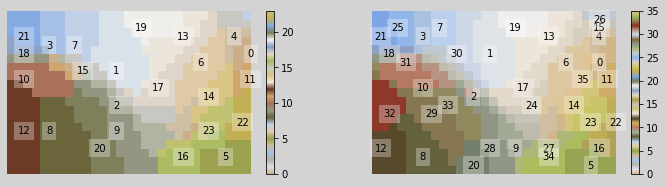

In [12]:
# 24色と36色を追加実験
plt.figure(figsize = (12,3), facecolor="lightgray")
plt.subplot(1,2,1)
plt.axis('off')
som_clustering(W,k=24)
plt.subplot(1,2,2)
som_clustering(W,k=36)
plt.axis('off')

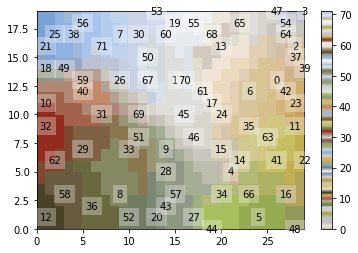

In [13]:
# 72色を追加実験
som_clustering(W,k=72)